# Lab 5 : Mixture Models+Model orden selection

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MSc - TD5"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L5_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

### First part

Fill in the following class to implement a multivariate GMM:

$\mu = \frac{1}{n} \sum_{i=1}^n x_i$

In [173]:
class my_GMM():

    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components

        Attributes:

        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None

    def fit(self, X):
        """ Find the parameters
        that better fit the data

        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix

        Returns:
        -----
        self
        """
        n, p = X.shape

        def compute_condition_prob_matrix(X, alpha, mu, Sigma):
            '''Compute the conditional probability matrix
            shape: (n, K)
            '''
            prob_matrix = np.zeros((n, self.k))

            for i in range(self.k):
                det_Sigma = np.linalg.det(Sigma[i])
                inv_Sigma = np.linalg.inv(Sigma[i])

                diff = X - mu[i]
                exponent = np.sum(np.dot(diff, inv_Sigma) * diff, axis=1)

                prefactor = 1 / ((2 * np.pi) ** (p / 2) * np.sqrt(det_Sigma))

                prob_matrix[:, i] = alpha[i] * prefactor * np.exp(-0.5 * exponent)

            return prob_matrix

        # TODO:
        # initialize the parameters
        # apply sklearn kmeans or randomly initialize them
        kmeans = KMeans(n_clusters=self.k, random_state=0).fit(X) # We are initializing as K Means
        self.labels_ = kmeans.labels_
        self.alpha_ = np.bincount(self.labels_) / n
        self.mu_ = np.array([np.mean(X[self.labels_ == i], axis=0) for i in range(self.k)])
        self.Sigma_ = np.array([np.cov(X[self.labels_ == i].T) for i in range(self.k)])
        prev_log_likelihood = np.full((n*self.k,), 0)
        prev_sumlikelihood = 1000
        convergence = 0



        # While not(convergence)
        #     Compute conditional probability matrix
        #     Update parameters


        iterator=0
        while (convergence != 1):
            iterator +=1

            # Compute conditional probability matrix
            self.cond_prob_ = compute_condition_prob_matrix(X, self.alpha_, self.mu_, self.Sigma_)

            # Update parameters
            Nk = np.sum(self.cond_prob_, axis=0)
            # Update alpha
            self.alpha_ = Nk / n
            self.alpha_ /= np.sum(self.alpha_)
            # Update mu
            self.mu_ = np.dot(self.cond_prob_.T, X) / Nk[:, np.newaxis]

            # Update Sigma
            self.Sigma_ = np.zeros((self.k, p, p))
            for i in range(self.k):
                for j in range(n):
                    diff = X[j] - self.mu_[i]
                    self.Sigma_[i] += self.cond_prob_[j, i] * np.outer(diff, diff)
                self.Sigma_[i] /= Nk[i]

            new_labels =    np.argmax(self.cond_prob_, axis=1)
            if (sum(new_labels-self.labels_)) ==0:
              convergence = 1
            self.labels_ = new_labels



        # Update labels_

        return self

    def predict(self, X):
        """ Predict labels for X

        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix

        Returns:
        -----
        label assigment
        """
        return self.labels_

    def compute_proba(self, X):
        """ Compute probability vector for X

        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix

        Returns:
        -----
        proba: (n, k) np.array
        """

        return self.cond_prob_

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`.

Plot data with colors representing predicted labels and shapes representing real labels.

In [174]:

# Generate synthetic data with three Gaussian components
np.random.seed(42)

# Parameters for the three Gaussian components
mu1 = np.array([0, 0])
cov1 = np.array([[5, 0.8], [5, 1]])

mu2 = np.array([5, 5])
cov2 = np.array([[1, -0.5], [-0.5, 1]])

mu3 = np.array([-5, 5])
cov3 = np.array([[1, 0.5], [0.5, 1]])

# Number of samples for each component
n_samples = 50000

# Generate data
data1 = np.random.multivariate_normal(mu1, cov1, n_samples)
data2 = np.random.multivariate_normal(mu2, cov2, n_samples)
data3 = np.random.multivariate_normal(mu3, cov3, n_samples)

# Combine data from the three components
data = np.vstack((data1, data2, data3))

# True labels (for later comparison)
true_labels = np.repeat(np.arange(3), n_samples)

# Shuffle the data
shuffle_idx = np.arange(data.shape[0])
np.random.shuffle(shuffle_idx)
data = data[shuffle_idx]
true_labels = true_labels[shuffle_idx]



<ipython-input-174-fbb0c36f6b43>:18: RuntimeWarning: covariance is not positive-semidefinite.
  data1 = np.random.multivariate_normal(mu1, cov1, n_samples)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


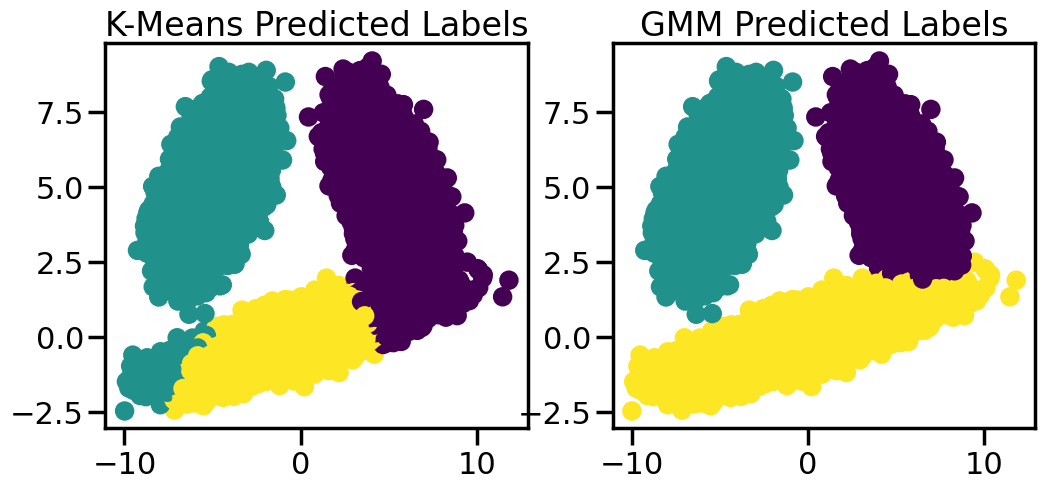

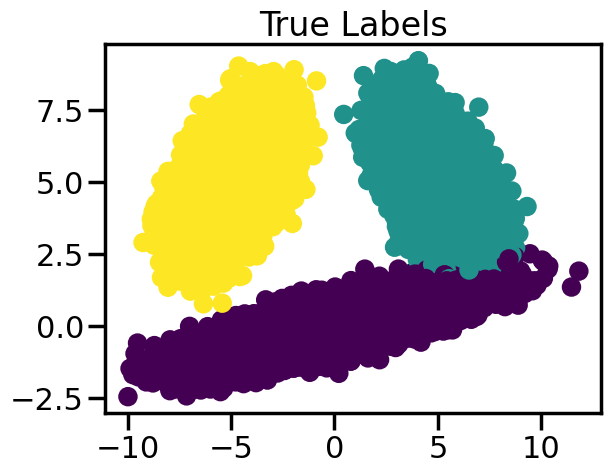

In [175]:
# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_labels = kmeans.fit_predict(data)

# Fit your GMM
gmm = my_GMM(k=3)
gmm.fit(data)
gmm_labels = gmm.predict(data)

# Visualize the predicted labels
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, marker='o', cmap='viridis')
plt.title("K-Means Predicted Labels")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=gmm_labels, marker='o', cmap='viridis')
plt.title("GMM Predicted Labels")

plt.show()

# Visualize the true labels
plt.scatter(data[:, 0], data[:, 1], c=true_labels, marker='o', cmap='viridis')
plt.title("True Labels")
plt.show()
